In [1]:
import pickle
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests

# Motif Pair Search Across In Vivo Datasets

### Loading ChIP-seq peaks

In [2]:
# Load FoxP3 ChIP-seq peak sequences
foxp3_peak_sequences = pd.read_csv('figure3_files/foxp3_chipseq_peak_sequences.csv')

In [3]:
foxp3_peak_sequences.head()

,chr,start,end,sequence
0,1,3241741,3241906,GTATCTGTTGAGGCCTGTTTTGTGACCAATTATATGGTCAATTTTG...
1,1,3348853,3349060,AAAATTCCAACTCAATTCTTCAATGAATTAGAAGGAGCAATTTGCA...
2,1,3768258,3768453,TATTTGTGACTATTGAGAAGGGTGTTGTTTCCCTAATTTCTTTCTC...
3,1,4084204,4084359,TATGTGTCGGGAGGAATTTCTTTTCTGGTCCAGTCTATTTGGAGTT...
4,1,4486722,4486910,TGGAACAACATTATAAACTAACCAGTACCCCGGAGCTCTTGACTCT...


### Example of building reg-ex motifs and searching for them

In [4]:
# Top 10 enriched motif sequences in forward and reverse-complement orientation
motifs_forward = ['NNAAACA', 'NAAACAN', 'NNCAACA', 'NCAACAN', 'ATGCGNN', 'GATGCNN', 'ATGCANN', 'AATGCNN', 'NATGCAN', 'ATGCNNC']
motifs_reverse = ['TGTTTNN', 'NTGTTTN', 'TGTTGNN', 'NTGTTGN', 'NNCGCAT', 'NNGCATC', 'NNTGCAT', 'NNGCATT', 'NTGCATN', 'GNNGCAT']

# Pairwise motif combinations for each orientation:
motif_combos_HH = [(r, f) for r in motifs_reverse for f in motifs_forward]
motif_combos_TT = [(f, r) for f in motifs_forward for r in motifs_reverse]
motif_combos_TH = [(f1, f2) for f1 in motifs_forward for f2 in motifs_forward]
motif_combos_HT = [(r1, r2) for r1 in motifs_reverse for r2 in motifs_reverse]

In [5]:
# Convert peak DataFrame into a list of tuples: (chrom, start, end, sequence)
chipseq_sequences = list(foxp3_peak_sequences.itertuples(index=False, name=None))

def generate_regex_motifs(motif_pairs):
    """
    Convert motif pairs into regex patterns with a fixed 4bp spacer between motifs.
    """
    return [
        f"{f.replace('N', '[ATGC]')}[ATGC]{{4}}{r.replace('N', '[ATGC]')}"
        for f, r in motif_pairs
    ]

def build_motif_regex_dict():
    """
    Generate a dictionary of regex motif patterns by orientation:
    """
    return {
        'HH': {i: p for i, p in enumerate(generate_regex_motifs(motif_combos_HH))},
        'TT': {i: p for i, p in enumerate(generate_regex_motifs(motif_combos_TT))},
        'TH': {i: p for i, p in enumerate(generate_regex_motifs(motif_combos_TH))},
        'HT': {i: p for i, p in enumerate(generate_regex_motifs(motif_combos_HT))}
    }

# Build all regex motif patterns
motif_regex_by_orientation = build_motif_regex_dict()

In [6]:
# Display 3 example regex motifs from each orientation
for orientation, motifs in motif_regex_by_orientation.items():
    print(f"Examples from orientation '{orientation}':")
    for i in list(motifs.keys())[:3]:
        print(f"  {i}: {motifs[i]}")
    print()

Examples from orientation 'HH':
  0: TGTTT[ATGC][ATGC][ATGC]{4}[ATGC][ATGC]AAACA
  1: TGTTT[ATGC][ATGC][ATGC]{4}[ATGC]AAACA[ATGC]
  2: TGTTT[ATGC][ATGC][ATGC]{4}[ATGC][ATGC]CAACA

Examples from orientation 'TT':
  0: [ATGC][ATGC]AAACA[ATGC]{4}TGTTT[ATGC][ATGC]
  1: [ATGC][ATGC]AAACA[ATGC]{4}[ATGC]TGTTT[ATGC]
  2: [ATGC][ATGC]AAACA[ATGC]{4}TGTTG[ATGC][ATGC]

Examples from orientation 'TH':
  0: [ATGC][ATGC]AAACA[ATGC]{4}[ATGC][ATGC]AAACA
  1: [ATGC][ATGC]AAACA[ATGC]{4}[ATGC]AAACA[ATGC]
  2: [ATGC][ATGC]AAACA[ATGC]{4}[ATGC][ATGC]CAACA

Examples from orientation 'HT':
  0: TGTTT[ATGC][ATGC][ATGC]{4}TGTTT[ATGC][ATGC]
  1: TGTTT[ATGC][ATGC][ATGC]{4}[ATGC]TGTTT[ATGC]
  2: TGTTT[ATGC][ATGC][ATGC]{4}TGTTG[ATGC][ATGC]



In [7]:
def match_and_count_patterns(sequences, regex_patterns):
    """
    Count how many times each regex pattern matches across all ChIP-seq peaks.
    """
    match_counts = defaultdict(int)
    for chrom, start, end, seq in sequences:
        if seq == "Sequence not found":
            continue
        for idx, pattern in regex_patterns.items():
            for _ in re.finditer(pattern, seq):
                match_counts[idx] += 1
    return match_counts

# Example test: match a single motif
example_patterns = {"Example": "TGTTT[ATGC]{2}[ATGC]{4}[ATGC]{2}AAACA"}
example_result = match_and_count_patterns(chipseq_sequences, example_patterns)

print(f"Example motif was found {example_result['Example']} times in the FoxP3 ChIP-seq dataset.")

Example motif was found 252 times in the FoxP3 ChIP-seq dataset.


### Load the rest of the motif counts for FoxP3 ChIP-seq and ATAC-seq

In [8]:
# Load all precomputed motif counts from all datasets
all_motif_counts = pd.read_pickle("figure3_files/all_motif_counts.pkl")

In [9]:
# Extract motif counts specific to FoxP3 ChIP-seq peaks
motif_counts_chipseq = {
    k: v for k, v in all_motif_counts.items() if "foxp3_chip" in k
}

# Extract motif counts specific to ATAC-seq peaks
motif_counts_atacseq = {
    k: v for k, v in all_motif_counts.items() if "atac" in k
}

# Binomial Normalization to Compare ChIP vs. ATAC

### Dot plot

In [10]:
# Handle logistics of plotting dots (RUN THIS)

def plot_enrichment_by_orientation(data_by_orientation):
    """
    Plots log-transformed FoxP3 vs ATAC motif occurrence with point size scaled by fold-change,
    and significance (FDR < 0.05) outlined in black.
    """
    orientation_labels = {
        "HH": "Head-to-Head",
        "HT": "Head-to-Tail",
        "TH": "Tail-to-Head",
        "TT": "Tail-to-Tail"
    }

    orientation_colors = {
        "HH": "red",
        "HT": "blue",
        "TH": "purple",
        "TT": "green"
    }

    plt.figure(figsize=(9, 7))

    for orientation, (x_vals, y_vals, sizes, highlights) in data_by_orientation.items():
        color = orientation_colors[orientation]
        label = orientation_labels[orientation]

        x_edge = [x for x, h in zip(x_vals, highlights) if h]
        y_edge = [y for y, h in zip(y_vals, highlights) if h]
        s_edge = [s for s, h in zip(sizes, highlights) if h]

        x_base = [x for x, h in zip(x_vals, highlights) if not h]
        y_base = [y for y, h in zip(y_vals, highlights) if not h]
        s_base = [s for s, h in zip(sizes, highlights) if not h]

        plt.scatter(x_base, y_base, s=s_base, color=color, alpha=0.6, edgecolors='none')
        plt.scatter(x_edge, y_edge, s=s_edge, color=color, alpha=0.6, edgecolors='none', label=label)
        plt.scatter(x_edge, y_edge, s=s_edge, facecolors='none', edgecolors='black', linewidths=2)

    # Label and formatting
    plt.xlabel("log₂(ATAC Motif Occurrence per Mb)")
    plt.ylabel("log₂(FoxP3 ChIP Motif Occurrence per Mb)")
    plt.title("Motif Enrichment: FoxP3 ChIP vs ATAC (Binomial Test + FC)")

    # Grid and axis range
    plt.grid(True)
    plt.xlim(-2.25, 4.5)
    plt.ylim(-1.5, 6.5)

    # Orientation legend
    orientation_legend = [
        Line2D([0], [0], marker='o', color='w', label=orientation_labels[o],
               markerfacecolor=orientation_colors[o], markersize=8, alpha=0.6)
        for o in ["HH", "HT", "TH", "TT"]
    ] + [
        Line2D([0], [0], marker='o', color='w', label='FDR < 0.05',
               markerfacecolor='none', markeredgecolor='black', markersize=8, alpha=0.8)
    ]
    plt.legend(handles=orientation_legend, title="Motif Orientation", loc='upper left')

    # Fold change (FC) size legend
    fc_values = [1, 2, 5]
    fc_legend = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='black',
               markersize=np.sqrt((5 * fc)**2), linewidth=1.5, label=f'FC = {fc}')
        for fc in fc_values
    ]
    plt.legend(handles=fc_legend, title="Fold Change Magnitude", loc='lower right')

    plt.tight_layout()
    plt.show()

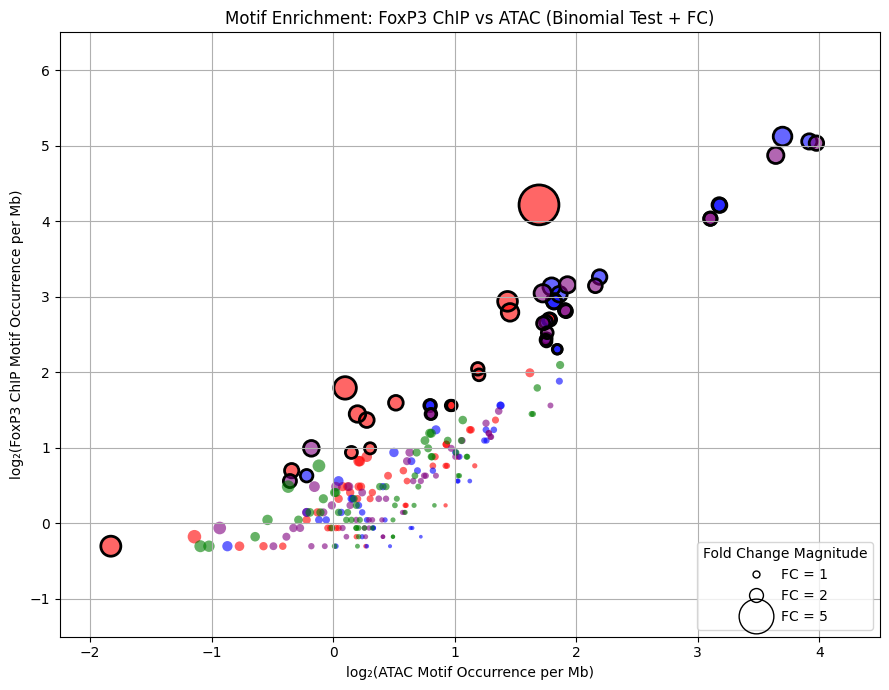

In [11]:
# Total number of base pairs for ChIP and ATAC peak datasets
total_bp_chip = 13_559_765
total_bp_atac = 127_983_250

def perform_binomial_enrichment_test(chip_counts, atac_counts, chip_bp, atac_bp):
    """
    Runs binomial enrichment tests and computes log2 RPM values and FC-based sizes.
    """
    x_vals, y_vals, fc_vals, pvals = [], [], [], []

    for motif_id, chip_count in chip_counts.items():
        atac_count = atac_counts.get(motif_id, 0)
        if chip_count <= 10 or atac_count <= 10:
            continue

        prob_null = atac_count / atac_bp
        if prob_null in (0, 1):
            continue

        test = binomtest(k=chip_count, n=chip_bp, p=prob_null, alternative='greater')
        pvals.append(test.pvalue)

        rpm_chip = chip_count / chip_bp * 1e6
        rpm_atac = atac_count / atac_bp * 1e6
        x_vals.append(rpm_atac)
        y_vals.append(rpm_chip)
        fc_vals.append(rpm_chip / rpm_atac)

    _, pvals_adj, _, _ = multipletests(pvals, method='fdr_bh')
    highlights = [p < 0.05 for p in pvals_adj]
    sizes = [(5 * fc)**2 for fc in fc_vals]

    return np.log2(x_vals), np.log2(y_vals), sizes, highlights

# Run tests for all orientations
enrichment_data = {
    "HH": perform_binomial_enrichment_test(
        motif_counts_chipseq['motif_counts_hh_foxp3_chip'],
        motif_counts_atacseq['motif_counts_hh_atac'],
        total_bp_chip, total_bp_atac
    ),
    "HT": perform_binomial_enrichment_test(
        motif_counts_chipseq['motif_counts_ht_foxp3_chip'],
        motif_counts_atacseq['motif_counts_ht_atac'],
        total_bp_chip, total_bp_atac
    ),
    "TH": perform_binomial_enrichment_test(
        motif_counts_chipseq['motif_counts_th_foxp3_chip'],
        motif_counts_atacseq['motif_counts_th_atac'],
        total_bp_chip, total_bp_atac
    ),
    "TT": perform_binomial_enrichment_test(
        motif_counts_chipseq['motif_counts_tt_foxp3_chip'],
        motif_counts_atacseq['motif_counts_tt_atac'],
        total_bp_chip, total_bp_atac
    )
}

# Plot
plot_enrichment_by_orientation(enrichment_data)

### Heatmap

In [12]:
# Handle logistics of plotting heatmap (RUN THIS)
def plot_motif_enrichment_heatmaps(orientation_matrices, title="Motif Enrichment Heatmap", colorbar_label="FP3 ChIP-seq Normalized Loci Count"):
    """
    Plots a 2x2 grid of heatmaps for each motif orientation with consistent scaling and visual annotations.

    Parameters:
        orientation_matrices (dict): Keys are orientation labels ("Head-to-Head", etc.), values are 10x10 numpy arrays.
        title (str): Optional title for the figure.
        colorbar_label (str): Label for the colorbar.
    """
    motif_labels_forward = ['NNAAACA', 'NAAACAN', 'NNCAACA', 'NCAACAN', 'ATGCGNN', 'GATGCNN', 'ATGCANN', 'AATGCNN', 'NATGCAN', 'ATGCNNC']
    motif_labels_reverse = ['TGTTTNN', 'NTGTTTN', 'TGTTGNN', 'NTGTTGN', 'NNCGCAT', 'NNGCATC', 'NNTGCAT', 'NNGCATT', 'NTGCATN', 'GNNGCAT']

    data = list(orientation_matrices.items())

    # Normalize all matrices to 0–100 scale
    all_values = np.concatenate([matrix.flatten() for _, matrix in data])
    global_min, global_max = np.min(all_values), np.max(all_values)
    data_scaled = [(name, (mat - global_min) / (global_max - global_min) * 100) for name, mat in data]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.03, wspace=0.03)
    heatmaps = []

    layout = {
        "Tail-to-Head": (0, 0, motif_labels_forward, motif_labels_forward),
        "Tail-to-Tail": (0, 1, motif_labels_reverse, motif_labels_forward),
        "Head-to-Head": (1, 0, motif_labels_forward, motif_labels_reverse),
        "Head-to-Tail": (1, 1, motif_labels_reverse, motif_labels_reverse),
    }

    for name, matrix in data_scaled:
        row, col, x_labels, y_labels = *layout[name],
        ax = axes[row, col]

        im = ax.imshow(matrix, cmap="Blues", aspect="equal", vmin=0, vmax=100)

        # Visual markers
        ax.axhline(3.5, color='white', linewidth=5)
        ax.axvline(3.5, color='white', linewidth=5)
        ax.add_patch(patches.Rectangle((-0.5, -0.5), 4, 4, edgecolor='red', linewidth=5, facecolor='none'))
        ax.add_patch(patches.Rectangle((-10.5, 3.5), 10, 6, edgecolor='green', linewidth=5, facecolor='none'))
        ax.add_patch(patches.Rectangle((3.5, -1.5), 6, 1, edgecolor='green', linewidth=5, facecolor='none'))

        # Axis ticks and labels
        if col == 0:
            ax.set_yticks(range(10))
            ax.set_yticklabels([""] * 10, fontsize=10)
            for tick in ax.get_yticklabels()[:4]: tick.set_color('red')
            for tick in ax.get_yticklabels()[4:]: tick.set_color('green')
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])

        if row == 1:
            ax.set_xticks([])
        else:
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()
            ax.set_xticks(range(10))
            ax.set_xticklabels([""] * 10, rotation=45, ha="left", fontsize=10)
            for tick in ax.get_xticklabels()[:4]: tick.set_color('red')
            for tick in ax.get_xticklabels()[4:]: tick.set_color('green')

        ax.text(0.5, -0.05, name, fontsize=12, ha='center', transform=ax.transAxes)
        heatmaps.append(im)

    # Colorbar
    cbar = fig.colorbar(heatmaps[0], ax=axes, location='right', fraction=0.02, pad=0.02, aspect=50, label=colorbar_label)
    plt.suptitle(title, fontsize=14)
    plt.show()

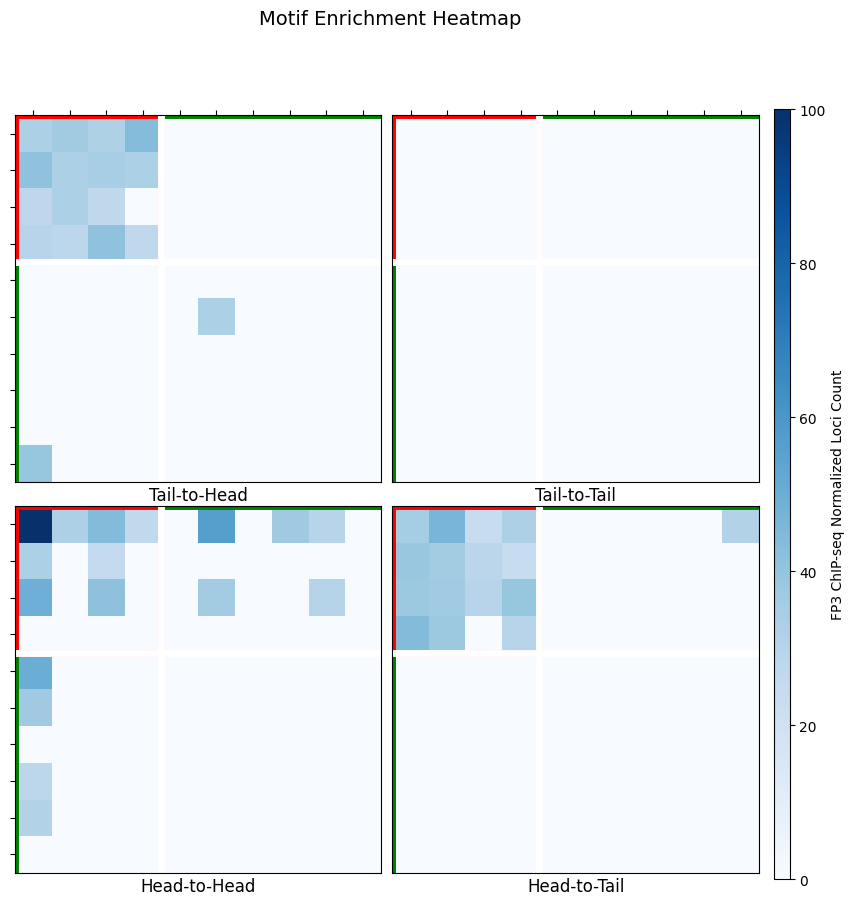

In [13]:
# Total bp in ChIP-seq and ATAC-seq peaks
chip_total_bp = 13_559_765
atac_total_bp = 127_983_250

def build_enrichment_heatmap(chip_counts, atac_counts, chip_bp, atac_bp):
    """
    Builds a 10x10 matrix of adjusted fold-changes where FoxP3 ChIP-seq is significantly enriched vs ATAC.
    Only cells with FDR < 0.05 are retained.
    """
    p_values = []
    fold_changes = []
    indices = []

    # Iterate through motifs
    for motif_idx, chip_count in chip_counts.items():
        atac_count = atac_counts.get(motif_idx, 0)

        # Skip low-count motifs
        if chip_count <= 10 or atac_count <= 10:
            continue

        # Expected probability under null (from ATAC)
        prob_null = atac_count / atac_bp
        if prob_null in (0, 1):
            continue

        # Binomial test: is FoxP3 ChIP significantly greater than ATAC?
        test = binomtest(k=chip_count, n=chip_bp, p=prob_null, alternative='greater')
        p_values.append(test.pvalue)
        indices.append(motif_idx)

        # Compute fold change using normalized RPM
        rpm_chip = chip_count / chip_bp * 1e6
        rpm_atac = atac_count / atac_bp * 1e6
        fc = rpm_chip / rpm_atac
        fold_changes.append(fc)

    # Initialize output matrix
    heatmap = np.zeros((10, 10))

    if not p_values:
        return heatmap

    # FDR correction
    _, pvals_adj, _, _ = multipletests(p_values, method='fdr_bh')

    # Populate matrix where FDR < 0.05
    for i, motif_idx in enumerate(indices):
        if pvals_adj[i] < 0.05:
            row, col = divmod(motif_idx, 10)
            heatmap[row, col] = fold_changes[i]

    return heatmap

# Compute heatmaps by orientation
heatmap_data = {
    "Head-to-Head": build_enrichment_heatmap(
        motif_counts_chipseq['motif_counts_hh_foxp3_chip'],
        motif_counts_atacseq['motif_counts_hh_atac'],
        chip_total_bp, atac_total_bp
    ),
    "Head-to-Tail": build_enrichment_heatmap(
        motif_counts_chipseq['motif_counts_ht_foxp3_chip'],
        motif_counts_atacseq['motif_counts_ht_atac'],
        chip_total_bp, atac_total_bp
    ),
    "Tail-to-Head": build_enrichment_heatmap(
        motif_counts_chipseq['motif_counts_th_foxp3_chip'],
        motif_counts_atacseq['motif_counts_th_atac'],
        chip_total_bp, atac_total_bp
    ),
    "Tail-to-Tail": build_enrichment_heatmap(
        motif_counts_chipseq['motif_counts_tt_foxp3_chip'],
        motif_counts_atacseq['motif_counts_tt_atac'],
        chip_total_bp, atac_total_bp
    ),
}

# Plot
plot_motif_enrichment_heatmaps(heatmap_data)

### Repeat this process for other datasets (FP1/ATAC, CnR/ATAC, etc)

# Motif Gap Size Correction and Analysis

In [14]:
def find_motif_gaps_example(sequences_in_bed):
    '''
    Search peaks to find gap preference of corrected motif
    '''
    
    matches_list = []

    # Only one motif for demonstration
    motif_name = 'TGTT[TG]_[CA]AACA'
    motif_start = r'TGTT[TG]'
    motif_end = r'[CA]AACA'

    # The true motif pattern is TGTTTNN + NNAAACA with 4 variable nucleotides in the middle
    # So, to test *true gap sizes* of 1–10 between the two parts,
    # we use gap lengths of 4–14 (because 4 are "used up" in the motif structure itself)
    gap_range = range(4, 14)  # This gives normalized gaps 0–9

    for chrom, start, end, seq in sequences_in_bed:
        if seq == "Sequence not found":
            continue

        for real_gap_size in gap_range:
            gap_pattern = f"[ATGC]{{{real_gap_size}}}"
            pattern = f"{motif_start}{gap_pattern}{motif_end}"
            regex = re.compile(pattern)

            for match in regex.finditer(seq):
                match_start = start + match.start()
                match_end = start + match.end()
                normalized_gap_index = real_gap_size - min(gap_range)   
                matches_list.append((chrom, match_start, match_end, motif_name, normalized_gap_index))

    df_matches = pd.DataFrame(matches_list, columns=['chr', 'start', 'end', 'motif', 'gap_size'])
    return df_matches

# Example only — use a subset for speed!
df_chip_example = find_motif_gaps_example(chipseq_sequences)

gap_counts_df = df_chip_example.groupby('gap_size').size().reset_index(name='count')

In [15]:
gap_counts_df

,gap_size,count
0,0,188
1,1,159
2,2,121
3,3,184
4,4,486
5,5,121
6,6,144
7,7,171
8,8,171
9,9,154


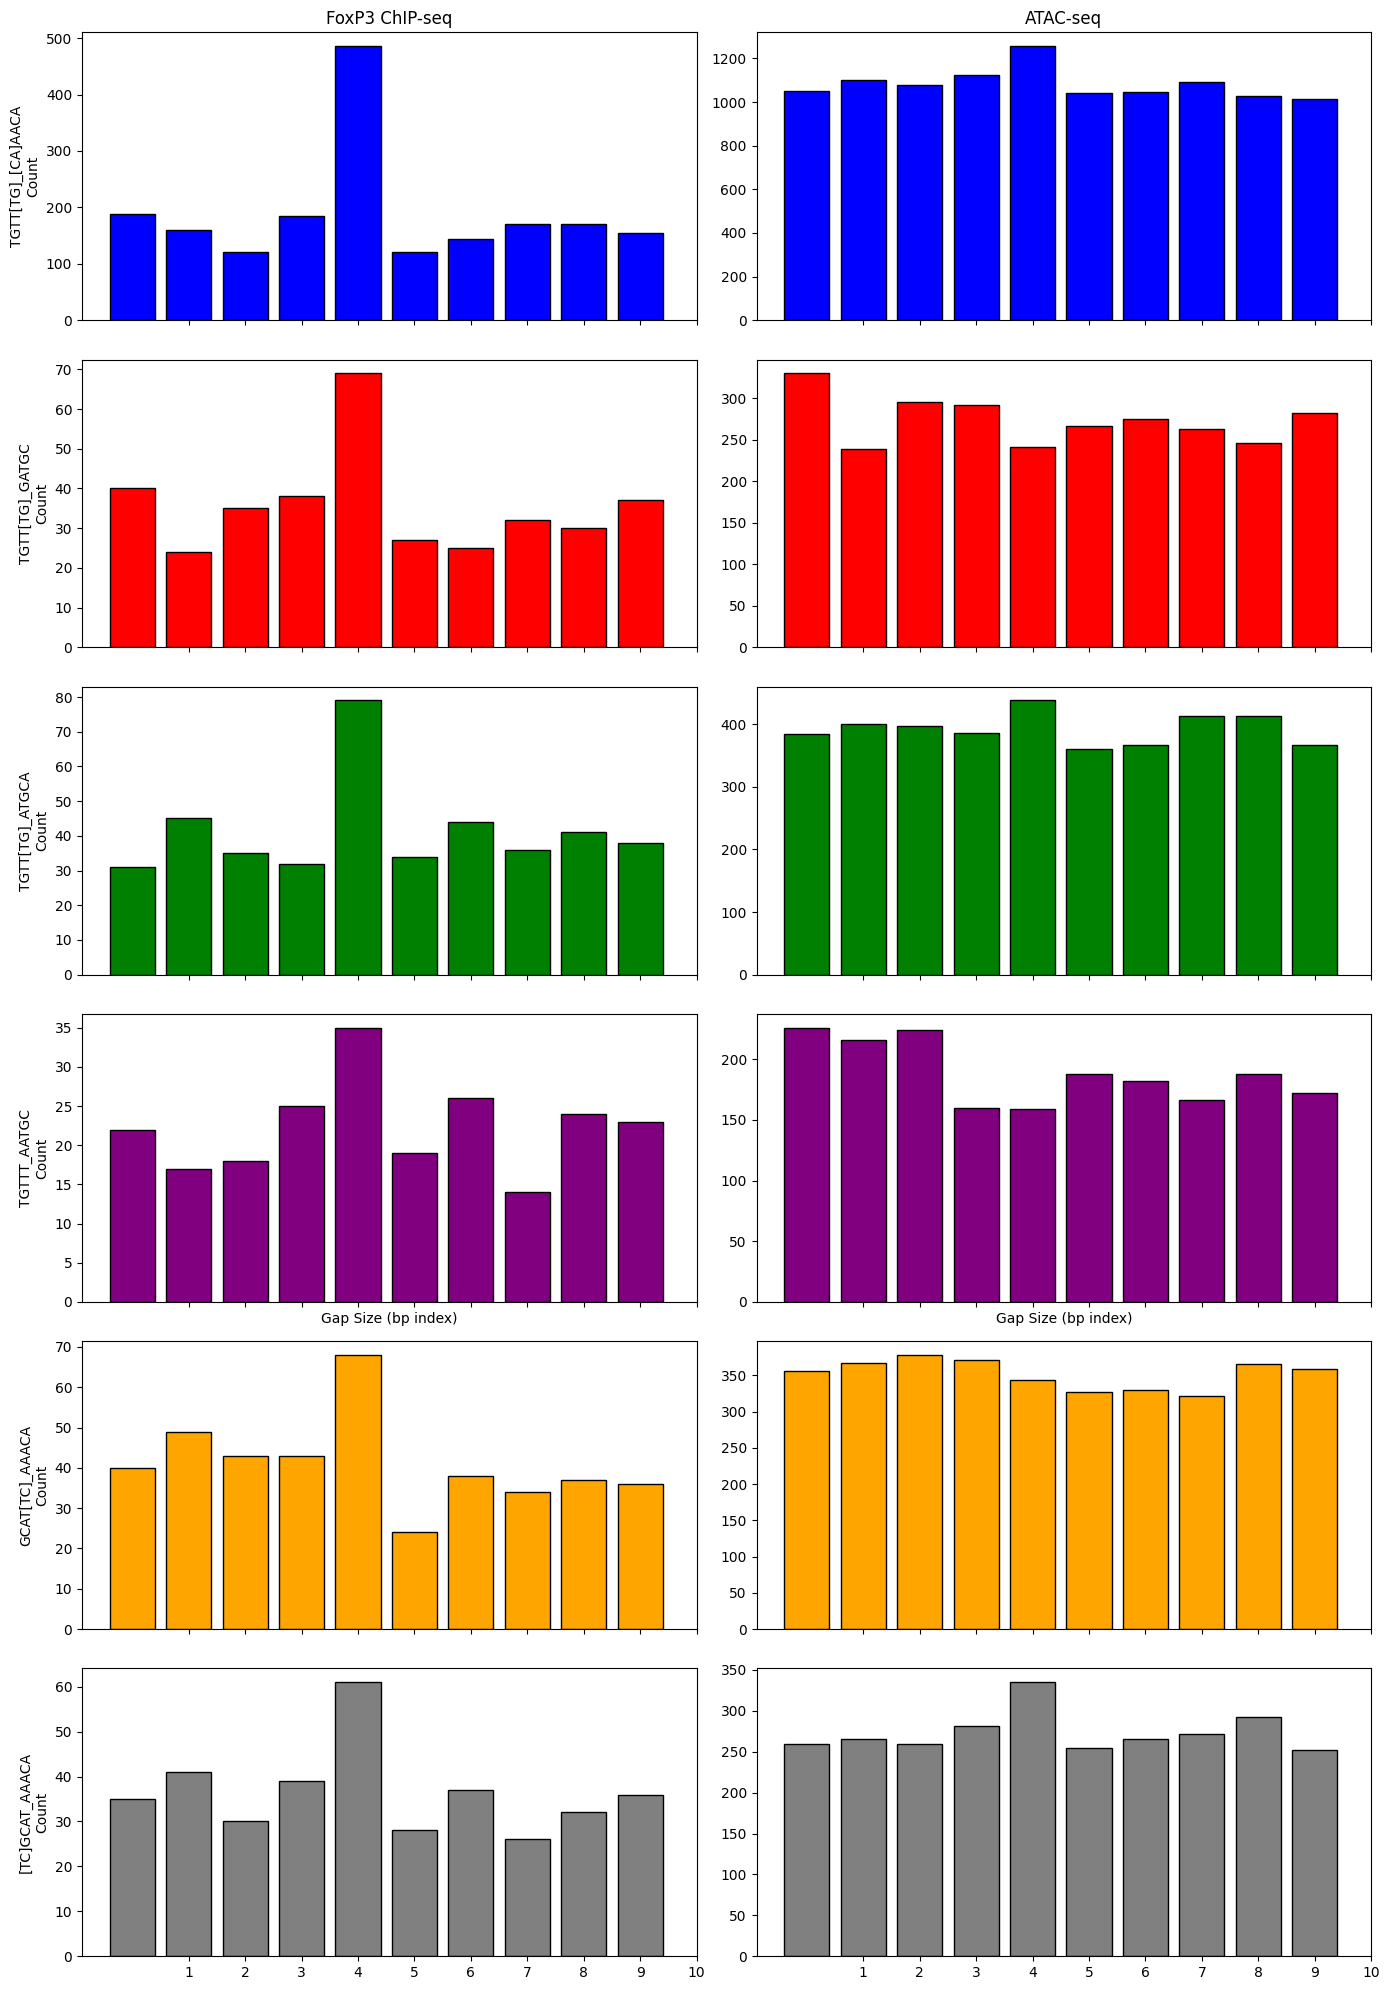

In [16]:
# Load the precomputed data
df_chip = pd.read_csv("figure3_files/gap_chip.csv")
df_atac = pd.read_csv("figure3_files/gap_atac.csv")

# Define motif order and color scheme
motif_colors = {
    'TGTT[TG]_[CA]AACA': 'blue',
    'TGTT[TG]_GATGC': 'red',
    'TGTT[TG]_ATGCA': 'green',
    'TGTTT_AATGC': 'purple',
    'GCAT[TC]_AAACA': 'orange',
    '[TC]GCAT_AAACA': 'gray',
}

motif_order = list(motif_colors.keys())

# Group and reindex for plotting
gap_motif_counts_chip = df_chip.groupby(['gap_size', 'motif']).size().unstack(fill_value=0)
gap_motif_counts_chip = gap_motif_counts_chip.reindex(columns=motif_order, fill_value=0)

gap_motif_counts_atac = df_atac.groupby(['gap_size', 'motif']).size().unstack(fill_value=0)
gap_motif_counts_atac = gap_motif_counts_atac.reindex(columns=motif_order, fill_value=0)

# Set up the figure: 6 rows (motifs) x 2 columns (ChIP vs ATAC)
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14, 20), sharex=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

for row_idx, motif in enumerate(motif_order):
    # FoxP3 ChIP-seq plot
    axes[row_idx, 0].bar(
        gap_motif_counts_chip.index,
        gap_motif_counts_chip[motif],
        color=motif_colors[motif],
        edgecolor='black',
        width=0.8
    )
    axes[row_idx, 0].set_ylabel(f"{motif}\nCount", fontsize=10)
    if row_idx == 0:
        axes[row_idx, 0].set_title("FoxP3 ChIP-seq")

    # ATAC-seq plot
    axes[row_idx, 1].bar(
        gap_motif_counts_atac.index,
        gap_motif_counts_atac[motif],
        color=motif_colors[motif],
        edgecolor='black',
        width=0.8
    )
    if row_idx == 0:
        axes[row_idx, 1].set_title("ATAC-seq")

    # Add X-axis labels only for the last row
    if row_idx == 3:
        axes[row_idx, 0].set_xlabel("Gap Size (bp index)", fontsize=10)
        axes[row_idx, 1].set_xlabel("Gap Size (bp index)", fontsize=10)

    # Consistent x-axis ticks across plots
    axes[row_idx, 0].set_xticks(range(1, 11))
    axes[row_idx, 1].set_xticks(range(1, 11))

plt.tight_layout()
plt.show()
